# 舞伴的影响


C:\Users\kqdx\AppData\Local\Temp\ipykernel_3948\2791272986.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_growth, x='avg_judge_improvement', y='ballroom_partner', palette='Greens_d')


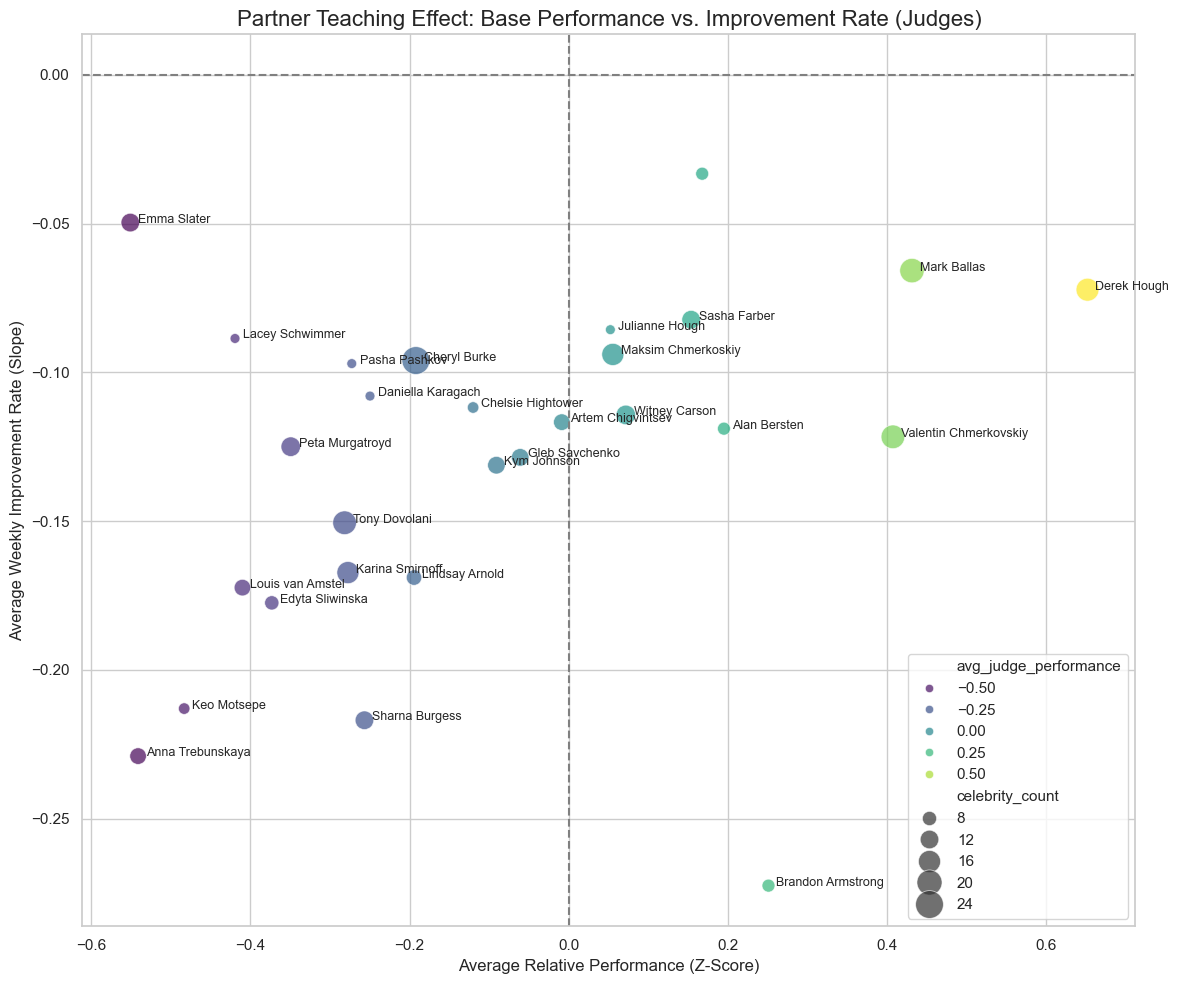

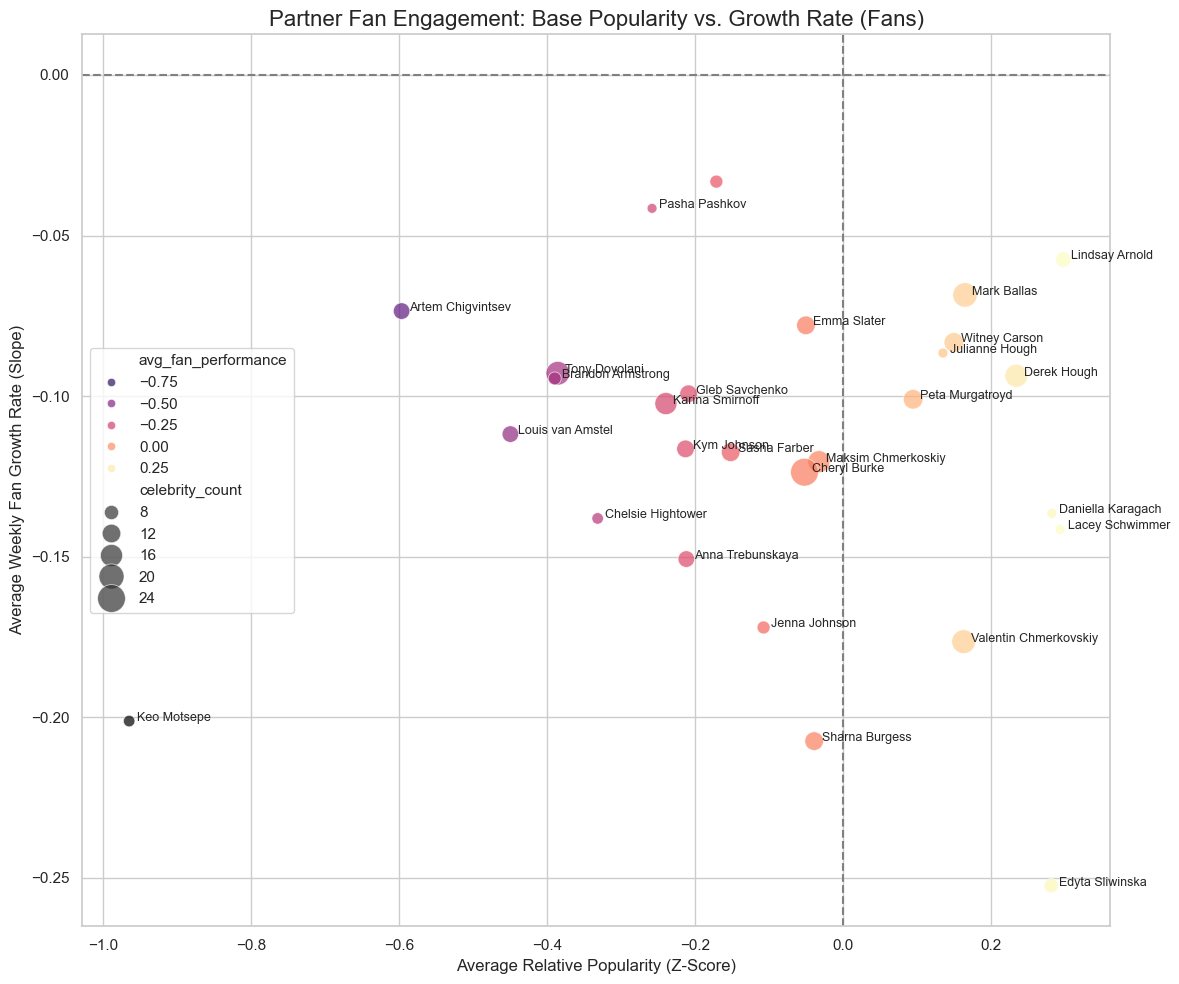

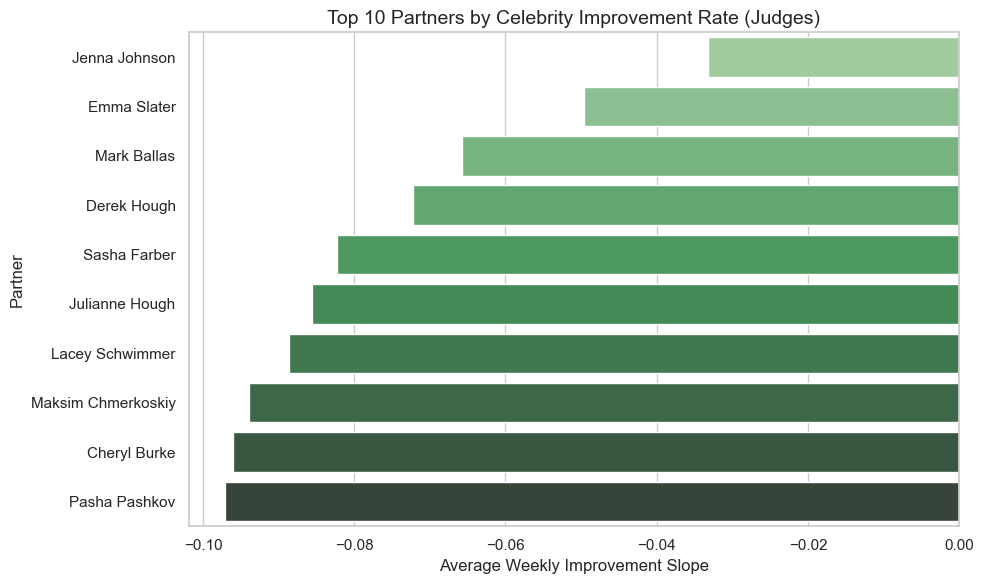

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from pathlib import Path

output_dir = Path.cwd()
if output_dir.name != "paper_writing":
    if (output_dir / "paper_writing").is_dir():
        output_dir = output_dir / "paper_writing"
    else:
        output_dir = output_dir / "paper" / "paper_writing"
output_dir.mkdir(parents=True, exist_ok=True)

# 读取数据
df = pd.read_csv("汇总表.csv")

# 1. 数据标准化 (Z-Score)
# 消除赛季差异，计算每周的相对表现
weekly_stats = df.groupby(['season', 'week']).agg(
    judge_mean=('judges_total_score', 'mean'),
    judge_std=('judges_total_score', 'std'),
    fan_mean=('estimated_fan_votes', 'mean'),
    fan_std=('estimated_fan_votes', 'std')
).reset_index()

df_merged = df.merge(weekly_stats, on=['season', 'week'], how='left')

def safe_z_score(val, mean, std):
    if std == 0 or np.isnan(std):
        return 0
    return (val - mean) / std

df_merged['judge_z'] = df_merged.apply(lambda x: safe_z_score(x['judges_total_score'], x['judge_mean'], x['judge_std']), axis=1)
df_merged['fan_z'] = df_merged.apply(lambda x: safe_z_score(x['estimated_fan_votes'], x['fan_mean'], x['fan_std']), axis=1)

# 2. 计算每位选手的“成长斜率” (Slope)
# 筛选出至少参赛3周的选手以计算趋势
def calculate_slope(group, target_col):
    if len(group) < 3: 
        return np.nan
    # 计算 回归斜率 (Trend over weeks)
    slope, intercept, r_value, p_value, std_err = linregress(group['week'], group[target_col])
    return slope

# 按赛季和明星聚合，计算个人成长轨迹
celebrity_trends = df_merged.groupby(['season', 'celebrity_name', 'ballroom_partner']).apply(
    lambda x: pd.Series({
        'judge_improvement_slope': calculate_slope(x, 'judge_z'),
        'fan_improvement_slope': calculate_slope(x, 'fan_z'),
        'avg_judge_z': x['judge_z'].mean(),
        'avg_fan_z': x['fan_z'].mean(),
        'weeks_competed': len(x)
    })
).reset_index().dropna()

# 3. 按舞伴聚合，评估舞伴的“教学能力”
partner_stats = celebrity_trends.groupby('ballroom_partner').agg(
    avg_judge_improvement=('judge_improvement_slope', 'mean'),
    avg_fan_improvement=('fan_improvement_slope', 'mean'),
    avg_judge_performance=('avg_judge_z', 'mean'), 
    avg_fan_performance=('avg_fan_z', 'mean'),     
    celebrity_count=('season', 'count')
).reset_index()

# 筛选资深舞伴 (带过至少5位明星)
experienced_partners = partner_stats[partner_stats['celebrity_count'] >= 5].sort_values(by='avg_judge_improvement', ascending=False)

# 4. 可视化绘图
sns.set(style="whitegrid")

# 图1: 评委眼中的“好老师”：平均水平 vs 成长速度
plt.figure(figsize=(12, 10))
sns.scatterplot(data=experienced_partners, x='avg_judge_performance', y='avg_judge_improvement', 
                size='celebrity_count', sizes=(50, 400), alpha=0.7, hue='avg_judge_performance', palette='viridis')

# 标注特定舞伴
for i, row in experienced_partners.iterrows():
    if abs(row['avg_judge_performance']) > 0.3 or abs(row['avg_judge_improvement']) > 0.05:
        plt.text(row['avg_judge_performance']+0.01, row['avg_judge_improvement'], row['ballroom_partner'], fontsize=9)

plt.title('Partner Teaching Effect: Base Performance vs. Improvement Rate (Judges)', fontsize=16)
plt.xlabel('Average Relative Performance (Z-Score)', fontsize=12)
plt.ylabel('Average Weekly Improvement Rate (Slope)', fontsize=12)
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.tight_layout()
plt.savefig(output_dir / 'partner_teaching_effect_judge.png')

# 图2: 观众缘的增长：平均人气 vs 吸粉速度
plt.figure(figsize=(12, 10))
sns.scatterplot(data=experienced_partners, x='avg_fan_performance', y='avg_fan_improvement', 
                size='celebrity_count', sizes=(50, 400), alpha=0.7, hue='avg_fan_performance', palette='magma')

for i, row in experienced_partners.iterrows():
    if abs(row['avg_fan_performance']) > 0.2 or abs(row['avg_fan_improvement']) > 0.05:
        plt.text(row['avg_fan_performance']+0.01, row['avg_fan_improvement'], row['ballroom_partner'], fontsize=9)

plt.title('Partner Fan Engagement: Base Popularity vs. Growth Rate (Fans)', fontsize=16)
plt.xlabel('Average Relative Popularity (Z-Score)', fontsize=12)
plt.ylabel('Average Weekly Fan Growth Rate (Slope)', fontsize=12)
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.tight_layout()
plt.savefig(output_dir / 'partner_growth_effect_fan.png')

# 图3: 最佳进步奖排名
plt.figure(figsize=(10, 6))
top_growth = experienced_partners.sort_values(by='avg_judge_improvement', ascending=False).head(10)
sns.barplot(data=top_growth, x='avg_judge_improvement', y='ballroom_partner', palette='Greens_d')
plt.title('Top 10 Partners by Celebrity Improvement Rate (Judges)', fontsize=14)
plt.xlabel('Average Weekly Improvement Slope')
plt.ylabel('Partner')
plt.tight_layout()
plt.savefig(output_dir / 'partner_improvement_ranking.png')

# 职业的影响

C:\Users\kqdx\AppData\Local\Temp\ipykernel_3948\3759090470.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=industry_stats_judge_sorted, x='avg_judge_z', y='celebrity_industry', palette='Blues_d')
C:\Users\kqdx\AppData\Local\Temp\ipykernel_3948\3759090470.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=industry_stats_fan_sorted, x='avg_fan_z', y='celebrity_industry', palette='Reds_d')


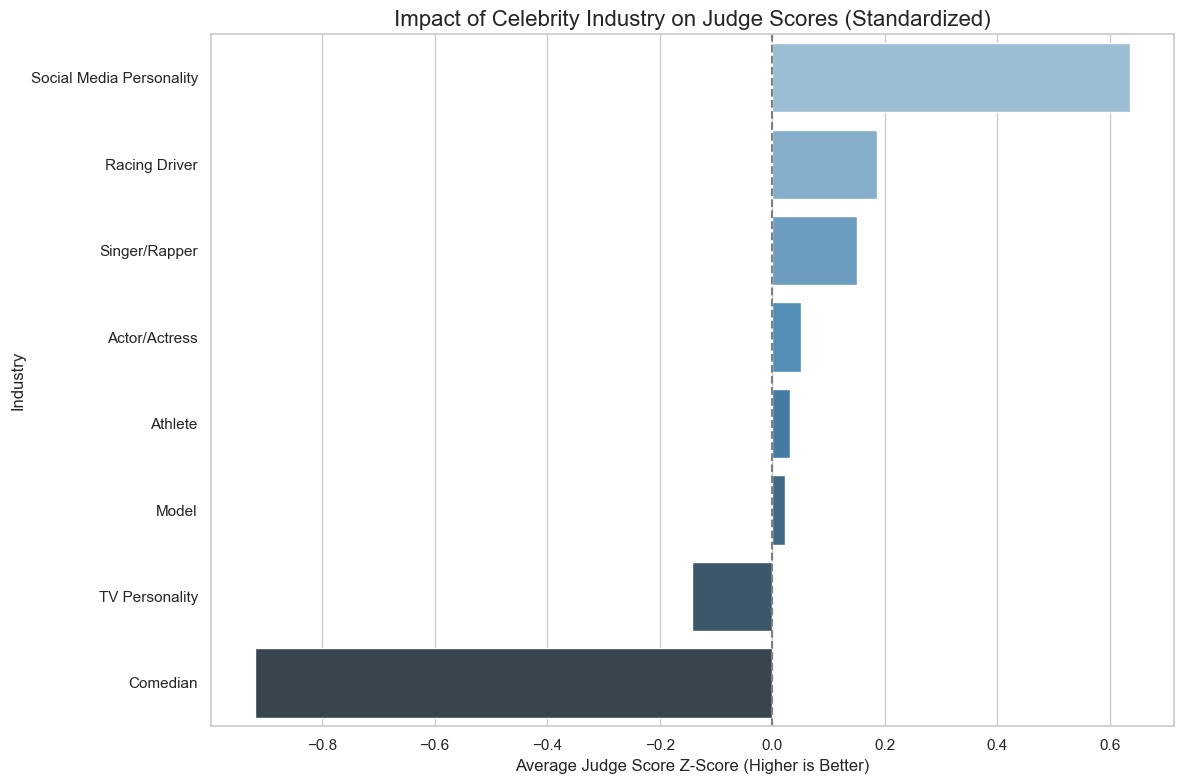

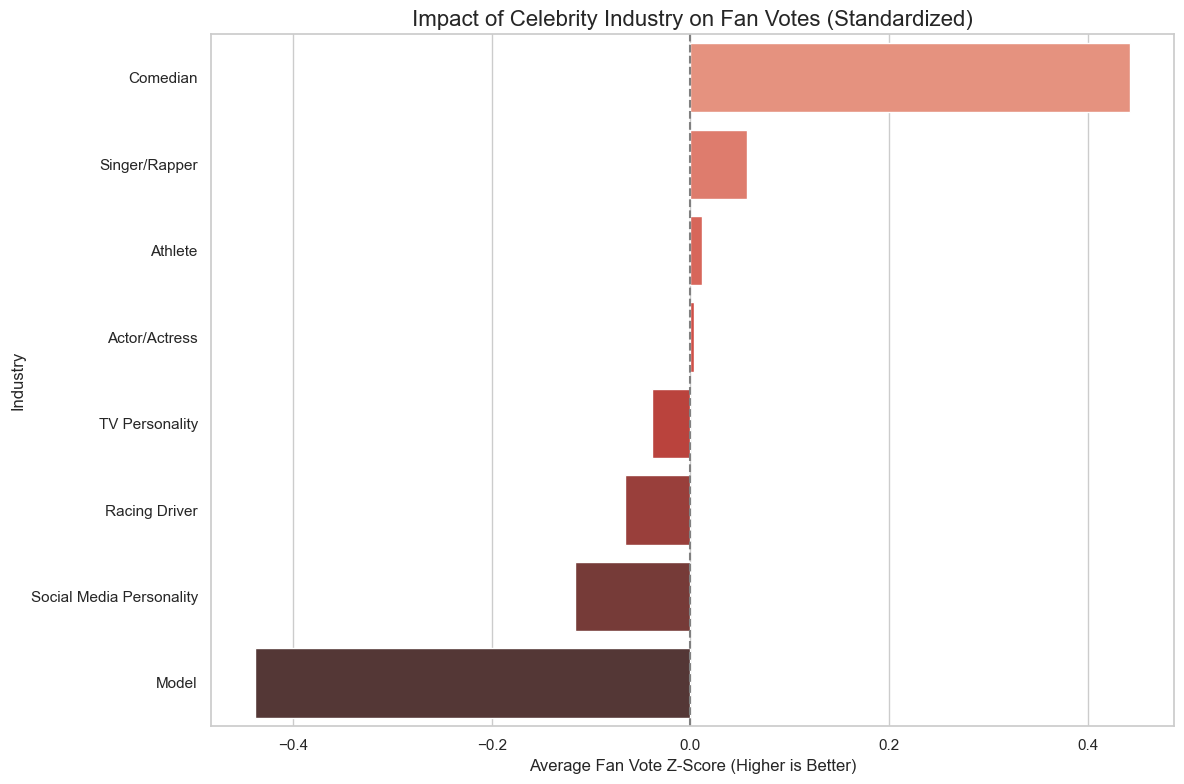

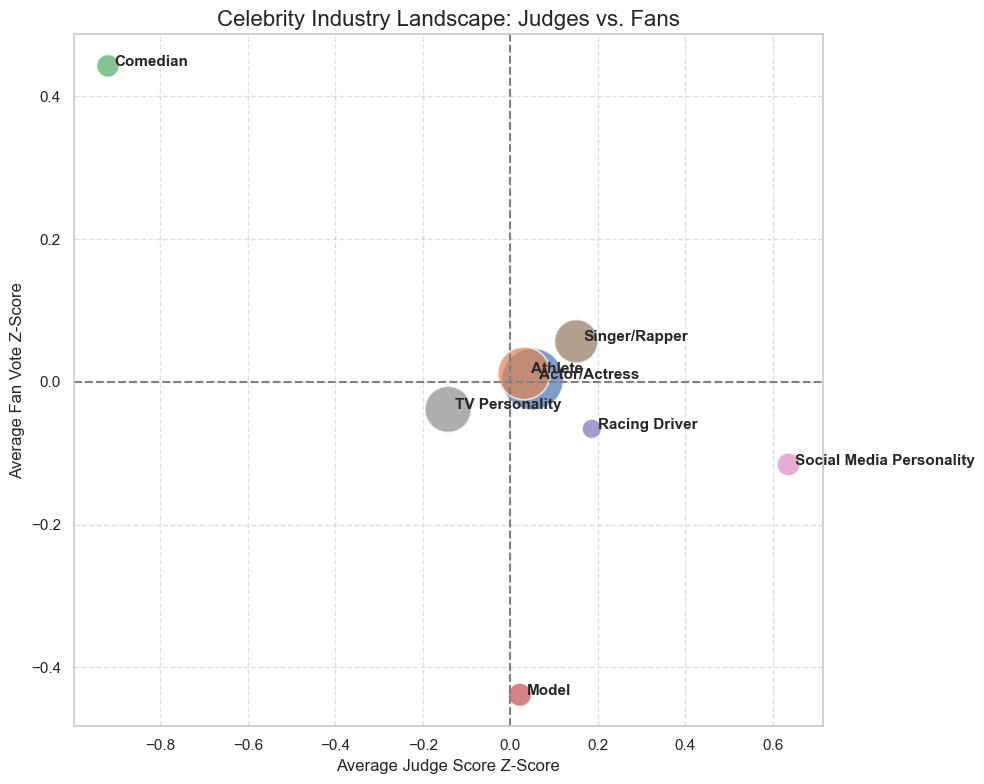

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

output_dir = Path.cwd()
if output_dir.name != "paper_writing":
    if (output_dir / "paper_writing").is_dir():
        output_dir = output_dir / "paper_writing"
    else:
        output_dir = output_dir / "paper" / "paper_writing"
output_dir.mkdir(parents=True, exist_ok=True)

# 读取数据
df = pd.read_csv("汇总表.csv")

# 1. 数据标准化 (Z-Score)
# 消除赛季和周次差异，计算相对表现
weekly_stats = df.groupby(['season', 'week']).agg(
    judge_mean=('judges_total_score', 'mean'),
    judge_std=('judges_total_score', 'std'),
    fan_mean=('estimated_fan_votes', 'mean'),
    fan_std=('estimated_fan_votes', 'std')
).reset_index()

df_merged = df.merge(weekly_stats, on=['season', 'week'], how='left')

def safe_z_score(val, mean, std):
    if std == 0 or np.isnan(std):
        return 0
    return (val - mean) / std

df_merged['judge_z'] = df_merged.apply(lambda x: safe_z_score(x['judges_total_score'], x['judge_mean'], x['judge_std']), axis=1)
df_merged['fan_z'] = df_merged.apply(lambda x: safe_z_score(x['estimated_fan_votes'], x['fan_mean'], x['fan_std']), axis=1)

# 2. 行业影响分析
# 统计各行业样本量
industry_counts = df_merged['celebrity_industry'].value_counts()

# 筛选样本量 >= 20 的主要行业，避免小样本偏差
valid_industries = industry_counts[industry_counts >= 20].index
df_filtered = df_merged[df_merged['celebrity_industry'].isin(valid_industries)]

# 按行业聚合计算均值
industry_stats = df_filtered.groupby('celebrity_industry').agg(
    avg_judge_z=('judge_z', 'mean'),
    avg_fan_z=('fan_z', 'mean'),
    count=('season', 'count')
).reset_index()

# 排序以便绘图
industry_stats_judge_sorted = industry_stats.sort_values(by='avg_judge_z', ascending=False)
industry_stats_fan_sorted = industry_stats.sort_values(by='avg_fan_z', ascending=False)

# 3. 可视化图表绘制
sns.set(style="whitegrid")

# 图1: 各行业评委评分表现 (Bar Chart)
plt.figure(figsize=(12, 8))
sns.barplot(data=industry_stats_judge_sorted, x='avg_judge_z', y='celebrity_industry', palette='Blues_d')
plt.title('Impact of Celebrity Industry on Judge Scores (Standardized)', fontsize=16)
plt.xlabel('Average Judge Score Z-Score (Higher is Better)', fontsize=12)
plt.ylabel('Industry', fontsize=12)
plt.axvline(0, color='grey', linestyle='--')
plt.tight_layout()
plt.savefig(output_dir / 'industry_judge_impact.png')

# 图2: 各行业粉丝投票表现 (Bar Chart)
plt.figure(figsize=(12, 8))
sns.barplot(data=industry_stats_fan_sorted, x='avg_fan_z', y='celebrity_industry', palette='Reds_d')
plt.title('Impact of Celebrity Industry on Fan Votes (Standardized)', fontsize=16)
plt.xlabel('Average Fan Vote Z-Score (Higher is Better)', fontsize=12)
plt.ylabel('Industry', fontsize=12)
plt.axvline(0, color='grey', linestyle='--')
plt.tight_layout()
plt.savefig(output_dir / 'industry_fan_impact.png')

# 图3: 行业综合定位图 (Scatter Plot)
plt.figure(figsize=(10, 8))
sns.scatterplot(data=industry_stats, x='avg_judge_z', y='avg_fan_z', 
                size='count', sizes=(200, 2000), hue='celebrity_industry', legend=False, alpha=0.7)

# 添加标签
for i, row in industry_stats.iterrows():
    plt.text(row['avg_judge_z'] + 0.015, row['avg_fan_z'], row['celebrity_industry'], fontsize=11, weight='bold')

plt.title('Celebrity Industry Landscape: Judges vs. Fans', fontsize=16)
plt.xlabel('Average Judge Score Z-Score', fontsize=12)
plt.ylabel('Average Fan Vote Z-Score', fontsize=12)
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(output_dir / 'industry_scatter.png')

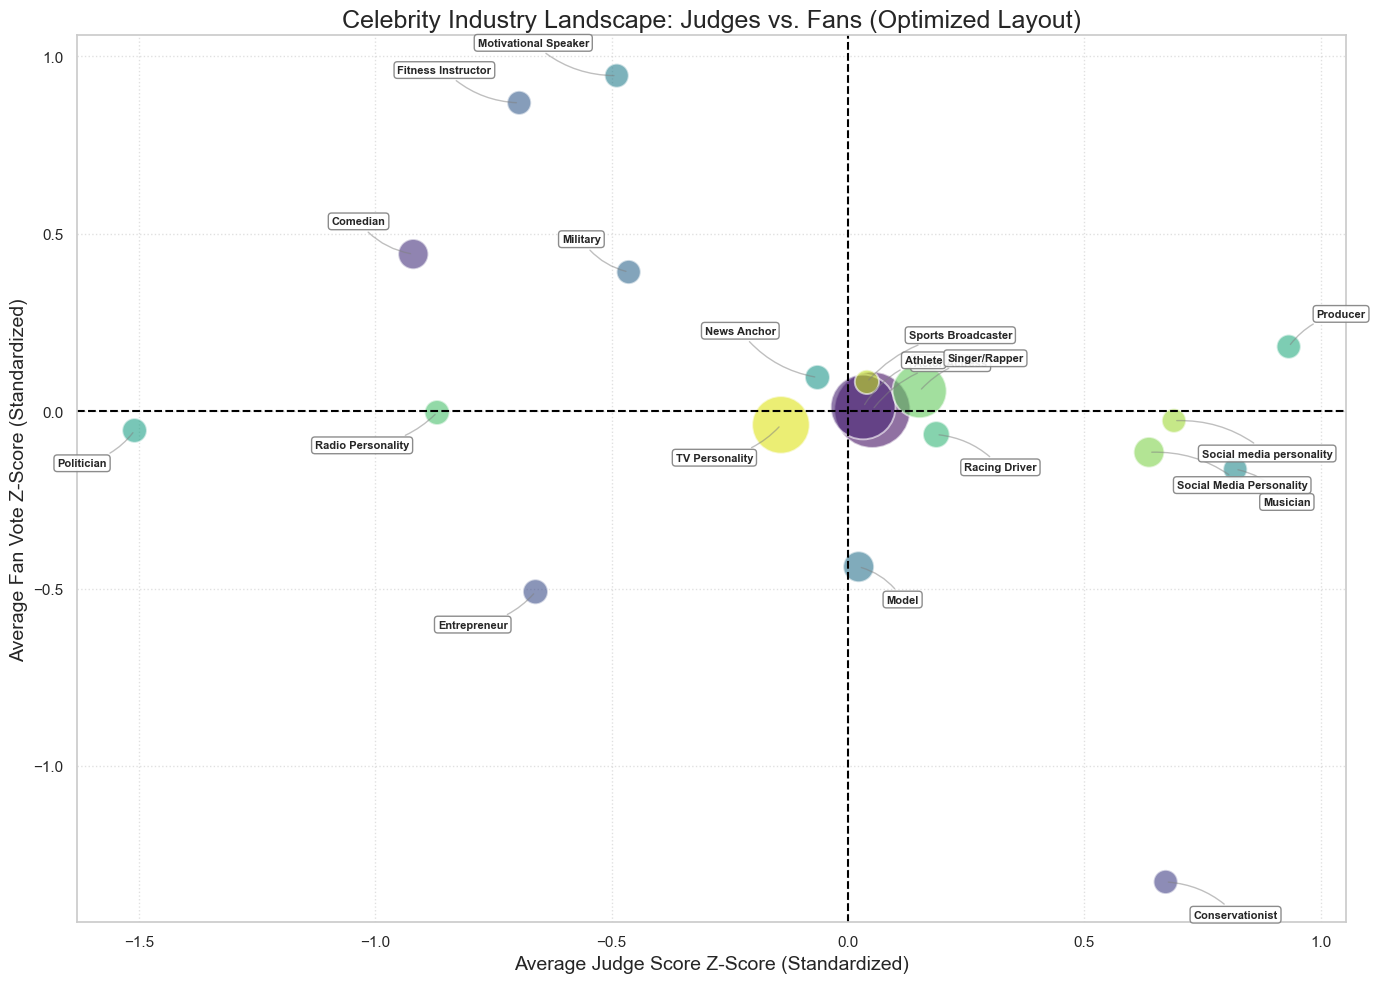

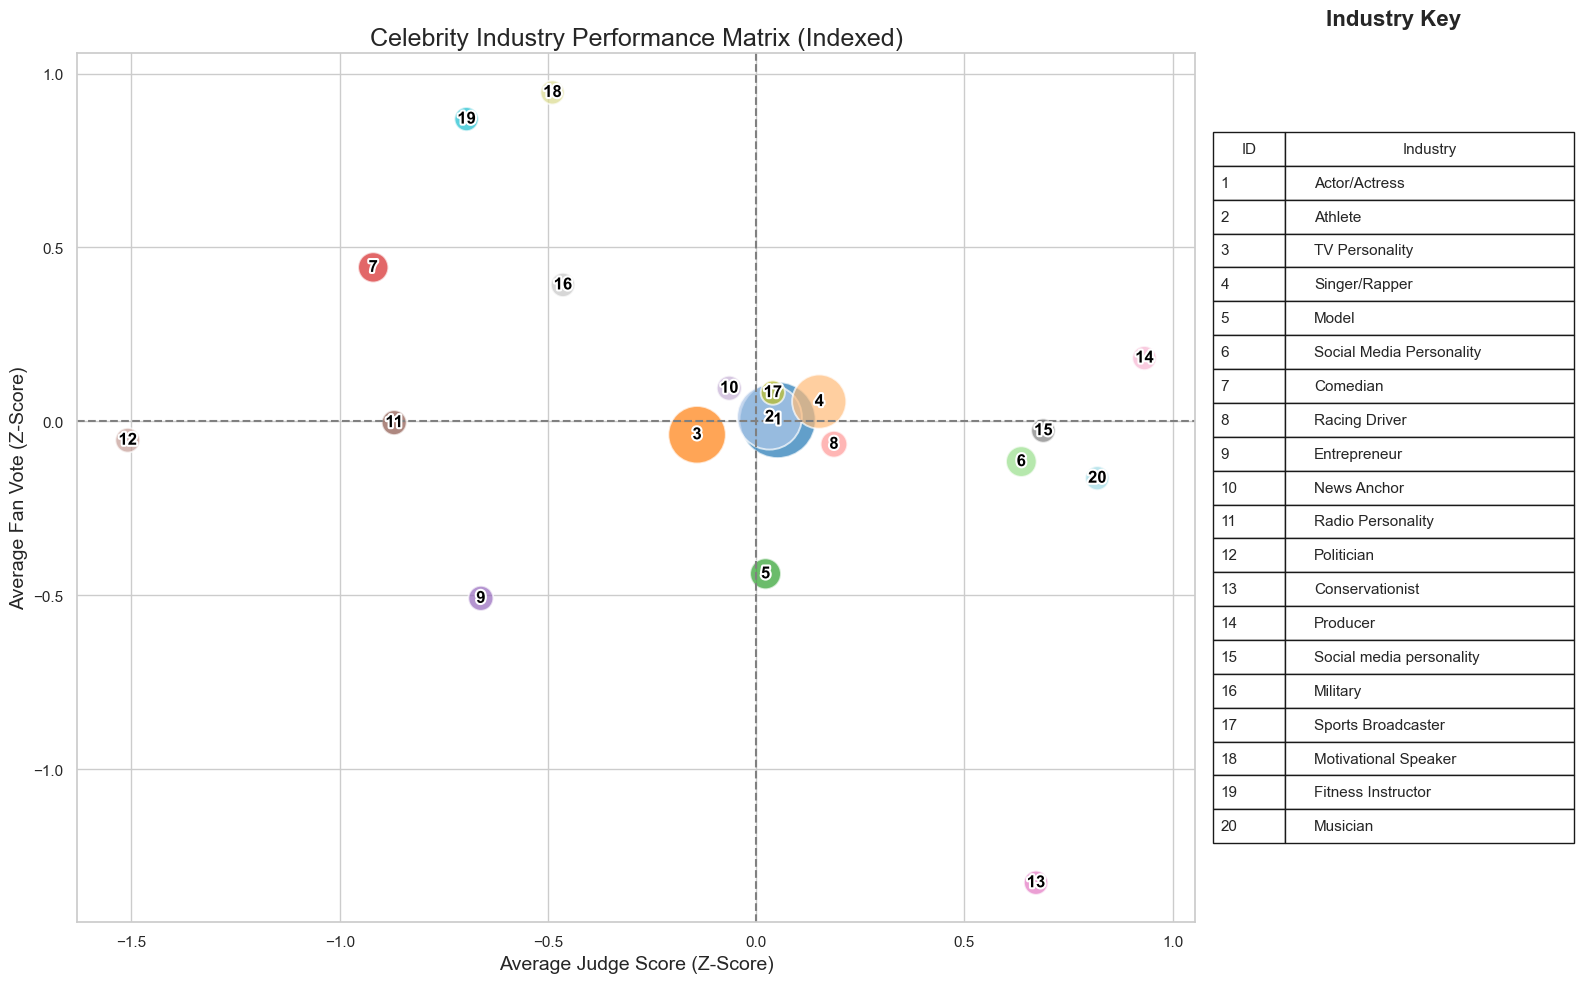

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

output_dir = Path.cwd()
if output_dir.name != "paper_writing":
    if (output_dir / "paper_writing").is_dir():
        output_dir = output_dir / "paper_writing"
    else:
        output_dir = output_dir / "paper" / "paper_writing"
output_dir.mkdir(parents=True, exist_ok=True)

# 读取数据
df = pd.read_csv("汇总表.csv")

# 1. 数据预处理：标准化 Z-Score 计算
weekly_stats = df.groupby(['season', 'week']).agg(
    judge_mean=('judges_total_score', 'mean'),
    judge_std=('judges_total_score', 'std'),
    fan_mean=('estimated_fan_votes', 'mean'),
    fan_std=('estimated_fan_votes', 'std')
).reset_index()

df_merged = df.merge(weekly_stats, on=['season', 'week'], how='left')

def safe_z_score(val, mean, std):
    if std == 0 or np.isnan(std):
        return 0
    return (val - mean) / std

df_merged['judge_z'] = df_merged.apply(lambda x: safe_z_score(x['judges_total_score'], x['judge_mean'], x['judge_std']), axis=1)
df_merged['fan_z'] = df_merged.apply(lambda x: safe_z_score(x['estimated_fan_votes'], x['fan_mean'], x['fan_std']), axis=1)

# 2. 行业聚合
industry_counts = df_merged['celebrity_industry'].value_counts()
# 过滤掉样本太少的职业，保留主要的
valid_industries = industry_counts[industry_counts >= 7].index
df_filtered = df_merged[df_merged['celebrity_industry'].isin(valid_industries)]

industry_stats = df_filtered.groupby('celebrity_industry').agg(
    avg_judge_z=('judge_z', 'mean'),
    avg_fan_z=('fan_z', 'mean'),
    count=('season', 'count')
).reset_index()

# 3. 绘制优化后的散点图
plt.figure(figsize=(14, 10))  # 增大画布
sns.set(style="whitegrid")

# 绘制气泡
sns.scatterplot(
    data=industry_stats, 
    x='avg_judge_z', 
    y='avg_fan_z', 
    size='count', 
    sizes=(300, 3000), # 增大气泡范围
    alpha=0.6, 
    hue='celebrity_industry', 
    legend=False,
    palette='viridis'
)

# 智能标签逻辑
for i, row in industry_stats.iterrows():
    x = row['avg_judge_z']
    y = row['avg_fan_z']
    label = row['celebrity_industry']
    
    # 策略：根据象限决定偏移方向，使标签向外发散
    # x >= 0, y >= 0 (第一象限): 文字往右上偏
    # x < 0, y < 0 (第三象限): 文字往左下偏
    x_offset = 20 if x >= 0 else -20
    y_offset = 20 if y >= 0 else -20
    
    # 如果点非常靠近中心，增加偏移量以防拥挤
    if abs(x) < 0.1 and abs(y) < 0.1:
        x_offset *= 1.5
        y_offset *= 1.5
        
    plt.annotate(
        label, 
        (x, y),
        textcoords="offset points", 
        xytext=(x_offset, y_offset),
        ha='left' if x_offset > 0 else 'right',
        va='bottom' if y_offset > 0 else 'top',
        fontsize=8,
        fontweight='bold',
        # 添加白色半透明背景框，防止遮挡
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.9),
        # 添加引导线
        arrowprops=dict(arrowstyle="-", connectionstyle="arc3,rad=0.2", color="gray", alpha=0.5)
    )

plt.title('Celebrity Industry Landscape: Judges vs. Fans (Optimized Layout)', fontsize=18)
plt.xlabel('Average Judge Score Z-Score (Standardized)', fontsize=14)
plt.ylabel('Average Fan Vote Z-Score (Standardized)', fontsize=14)

# 绘制中心轴线
plt.axhline(0, color='black', linestyle='--', linewidth=1.5)
plt.axvline(0, color='black', linestyle='--', linewidth=1.5)
plt.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.savefig(output_dir / 'industry_scatter_optimized.png')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as PathEffects

# 读取数据与计算 Z-Score (代码省略，与之前相同)
# ... (Standardization logic) ...

# 行业聚合与排序
industry_counts = df_merged['celebrity_industry'].value_counts()
valid_industries = industry_counts[industry_counts >= 7].index
df_filtered = df_merged[df_merged['celebrity_industry'].isin(valid_industries)]

industry_stats = df_filtered.groupby('celebrity_industry').agg(
    avg_judge_z=('judge_z', 'mean'),
    avg_fan_z=('fan_z', 'mean'),
    count=('season', 'count')
).reset_index()

# 按样本量排序并分配 ID
industry_stats = industry_stats.sort_values('count', ascending=False).reset_index(drop=True)
industry_stats['ID'] = industry_stats.index + 1

# 设置画布：左侧 3/4 为散点图，右侧 1/4 为图例表
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(1, 4)
ax_plot = fig.add_subplot(gs[0, 0:3])
ax_legend = fig.add_subplot(gs[0, 3])

sns.set_style("whitegrid")

# 绘制散点图
sns.scatterplot(
    data=industry_stats, 
    x='avg_judge_z', 
    y='avg_fan_z', 
    size='count', 
    sizes=(300, 3000), 
    alpha=0.7, 
    hue='celebrity_industry', 
    legend=False, 
    palette='tab20',
    ax=ax_plot
)

# 标注数字 ID
for i, row in industry_stats.iterrows():
    # 使用白色描边增强文字对比度
    txt = ax_plot.text(row['avg_judge_z'], row['avg_fan_z'], str(row['ID']), 
                 ha='center', va='center', fontsize=12, fontweight='bold', color='black')
    txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='white')])

ax_plot.set_title('Celebrity Industry Performance Matrix (Indexed)', fontsize=18)
ax_plot.set_xlabel('Average Judge Score (Z-Score)', fontsize=14)
ax_plot.set_ylabel('Average Fan Vote (Z-Score)', fontsize=14)
ax_plot.axhline(0, color='gray', linestyle='--')
ax_plot.axvline(0, color='gray', linestyle='--')

# 绘制右侧对照表
ax_legend.axis('off')
ax_legend.set_title("Industry Key", fontsize=16, fontweight='bold', pad=20)
table_data = [[row['ID'], row['celebrity_industry']] for i, row in industry_stats.iterrows()]

table = ax_legend.table(
    cellText=table_data, 
    colLabels=['ID', 'Industry'], 
    loc='center',
    cellLoc='left',
    colWidths=[0.2, 0.8]
)
table.scale(1, 1.8) # 拉高表格行距
table.auto_set_font_size(False)
table.set_fontsize(11)

plt.tight_layout()
plt.savefig(output_dir / 'industry_scatter_indexed.png')

# 不同地区的影响


C:\Users\kqdx\AppData\Local\Temp\ipykernel_3948\1073742863.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.boxplot(x='region_detailed', y='judges_total_score', data=df_filtered,
C:\Users\kqdx\AppData\Local\Temp\ipykernel_3948\1073742863.py:85: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, fontsize=10, color='black')


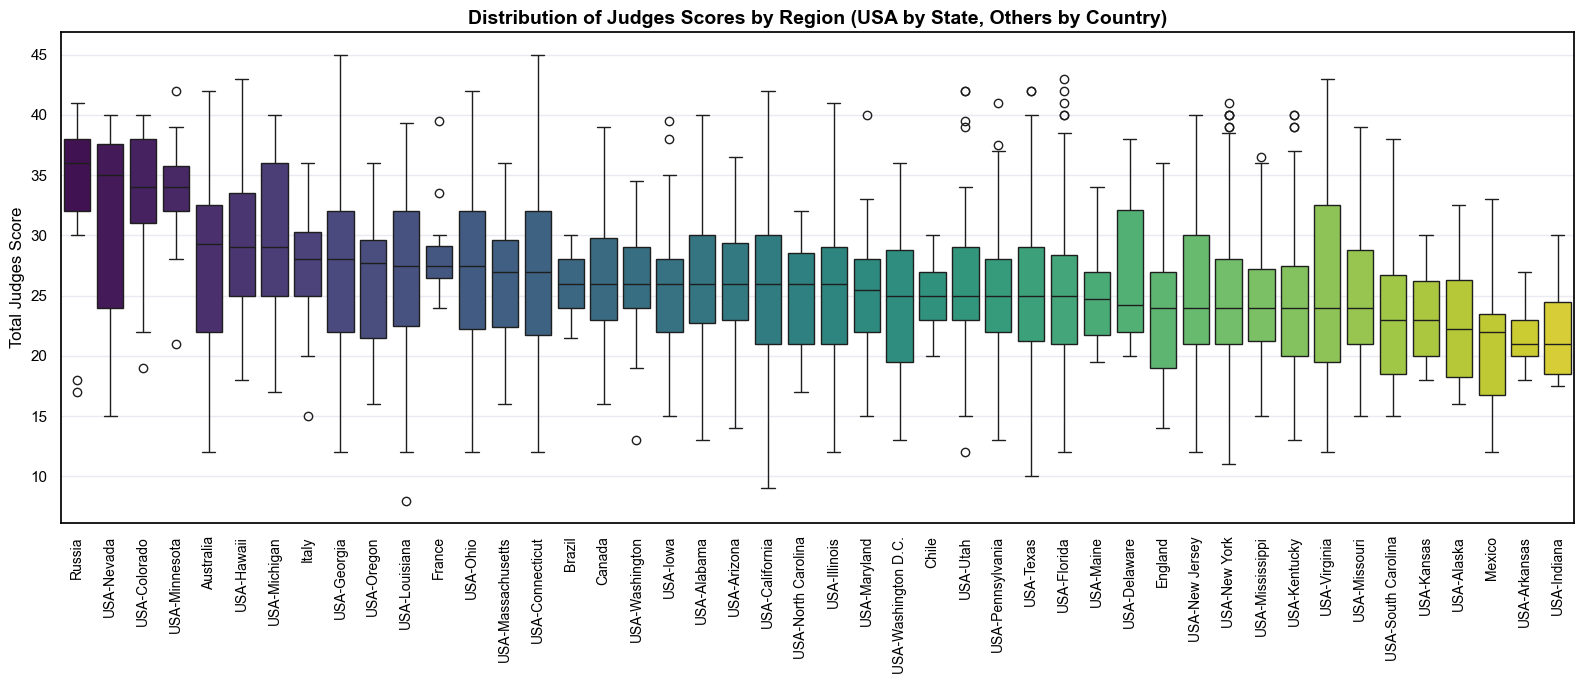

C:\Users\kqdx\AppData\Local\Temp\ipykernel_3948\1073742863.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.boxplot(x='region_detailed', y='estimated_fan_votes', data=df_filtered,
C:\Users\kqdx\AppData\Local\Temp\ipykernel_3948\1073742863.py:100: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90, fontsize=10, color='black')


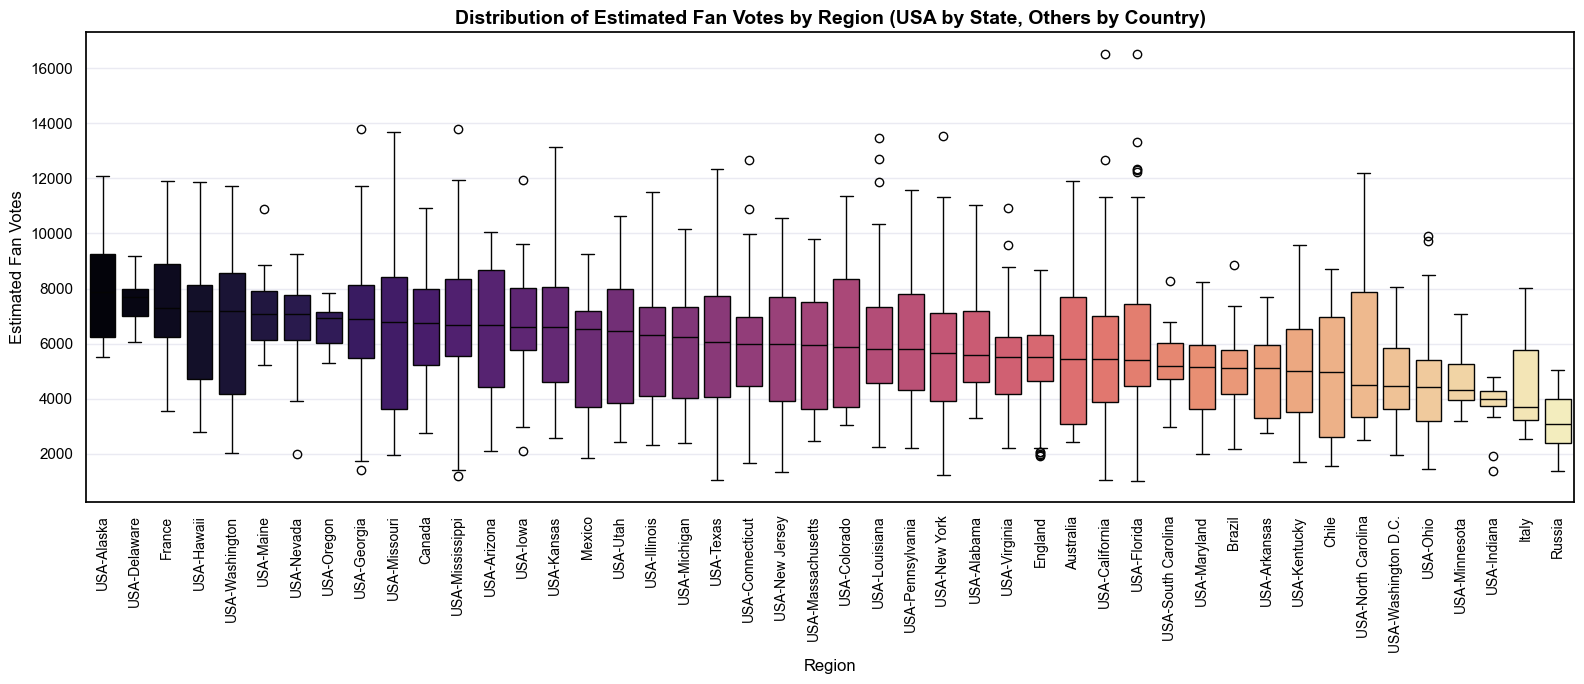

C:\Users\kqdx\AppData\Local\Temp\ipykernel_3948\1073742863.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax3 = sns.violinplot(x='region_detailed', y='judges_total_score', data=df_filtered,
C:\Users\kqdx\AppData\Local\Temp\ipykernel_3948\1073742863.py:114: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(ax3.get_xticklabels(), rotation=90, fontsize=10, color='black')


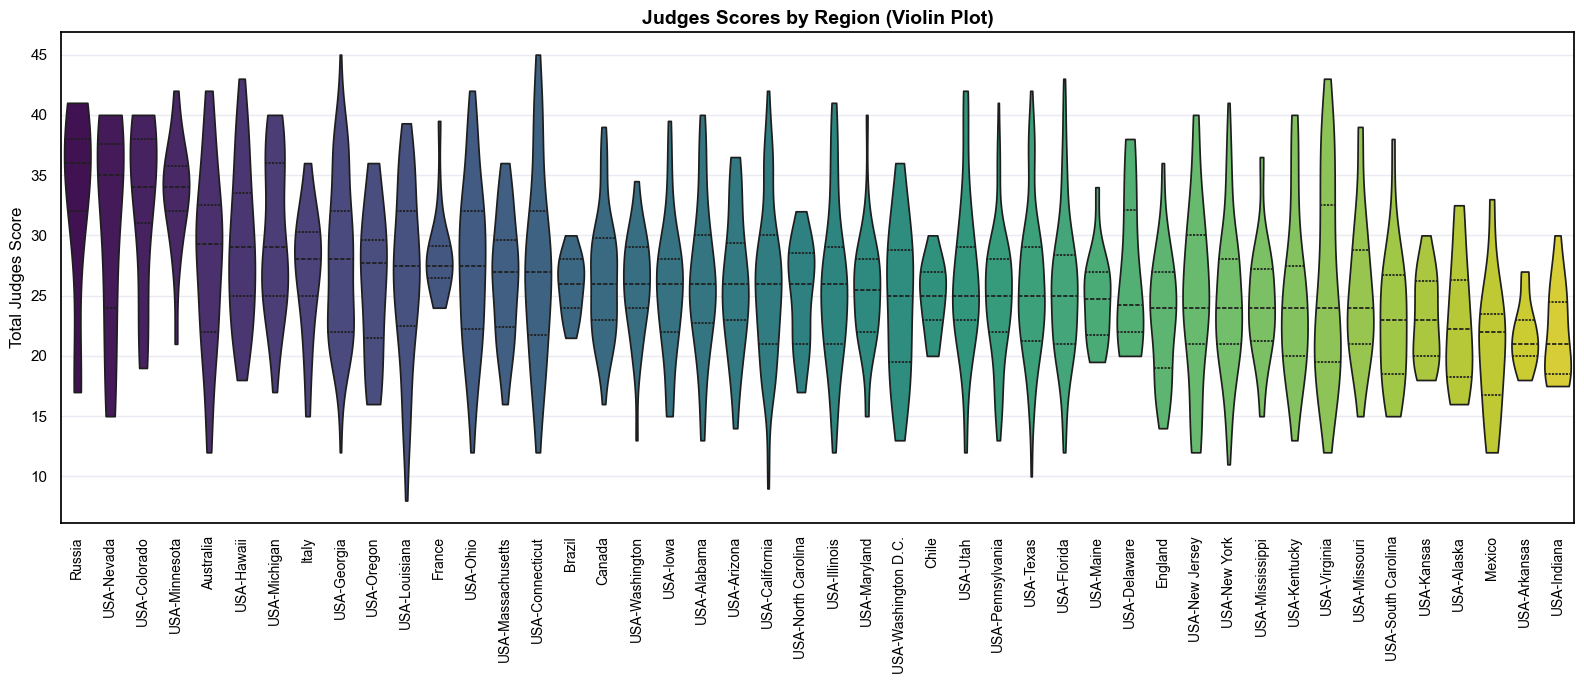

C:\Users\kqdx\AppData\Local\Temp\ipykernel_3948\1073742863.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax4 = sns.violinplot(x='region_detailed', y='estimated_fan_votes', data=df_filtered,
C:\Users\kqdx\AppData\Local\Temp\ipykernel_3948\1073742863.py:128: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(ax4.get_xticklabels(), rotation=90, fontsize=10, color='black')


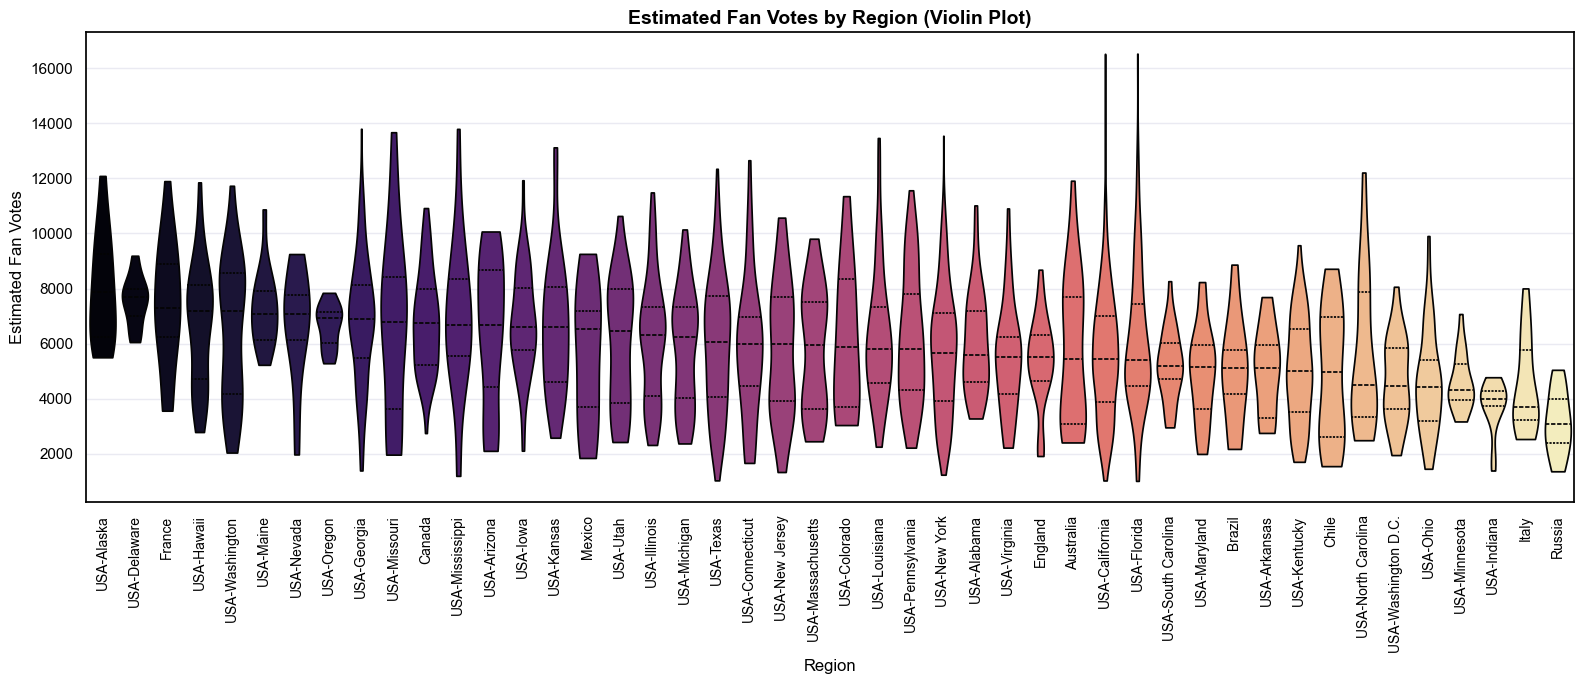


=== Top 10 Regions by Average Judges Score ===
region_detailed
USA-Minnesota    33.416667
Russia           32.954545
USA-Colorado     32.923077
USA-Nevada       30.933333
USA-Michigan     29.992647
USA-Hawaii       29.190909
Australia        28.297222
France           28.289474
USA-Georgia      28.073600
USA-Ohio         27.647887
Name: judges_total_score, dtype: float64

=== Top 10 Regions by Average Fan Votes ===
region_detailed
USA-Alaska         7951.857143
USA-Delaware       7545.500000
France             7386.473684
USA-Maine          7277.062500
USA-Mississippi    6937.129032
USA-Georgia        6863.584000
Canada             6806.089552
USA-Iowa           6772.704545
USA-Hawaii         6719.272727
USA-Nevada         6706.166667
Name: estimated_fan_votes, dtype: float64


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

output_dir = Path.cwd()
if output_dir.name != "paper_writing":
    if (output_dir / "paper_writing").is_dir():
        output_dir = output_dir / "paper_writing"
    else:
        output_dir = output_dir / "paper" / "paper_writing"
output_dir.mkdir(parents=True, exist_ok=True)

# -------------------------------------------------------------------------
# 1. Configuration & Load Data
# -------------------------------------------------------------------------
# Load data (Assuming file name is still the same, otherwise change it)
try:
    df = pd.read_csv('汇总表.csv')
except FileNotFoundError:
    print("Error: File '汇总表.csv' not found.")
    # Create dummy data for demonstration if file is missing
    df = pd.DataFrame({
        'celebrity_homecountry/region': np.random.choice(['United States', 'UK', 'Canada', 'Australia'], 500),
        'celebrity_homestate': np.random.choice(['California', 'New York', 'Texas', 'Florida', np.nan], 500),
        'judges_total_score': np.random.normal(25, 5, 500),
        'estimated_fan_votes': np.random.normal(10000, 2000, 500)
    })

# Set Plot Style: White background, Black text (Robust for IDE Dark Mode)
sns.set_style("whitegrid", {
    "axes.facecolor": "white",
    "figure.facecolor": "white",
    "axes.edgecolor": "black",
    "grid.color": "#EAEAF2", # Light grey grid
    "text.color": "black",
    "xtick.color": "black",
    "ytick.color": "black",
    "axes.labelcolor": "black"
})
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['text.color'] = 'black'

# ==========================================
# Core Logic: Define Detailed Regions
# ==========================================
def get_detailed_region(row):
    # Get country and state, strip whitespace
    country = str(row['celebrity_homecountry/region']).strip()
    state = str(row['celebrity_homestate']).strip()
    
    # Logic: If USA, return "USA-State"
    if country in ['United States', 'U.S.', 'USA']:
        if state and state.lower() != 'nan':
            return f"USA-{state}"
        else:
            return "USA-Unknown"
    else:
        # If other countries, return country name
        return country

# Apply function to create a new column
df['region_detailed'] = df.apply(get_detailed_region, axis=1)

# ==========================================
# Data Filtering & Visualization
# ==========================================
# Filter out regions with small sample sizes (e.g., < 10 weeks of data)
region_counts = df['region_detailed'].value_counts()
valid_regions = region_counts[region_counts > 10].index
df_filtered = df[df['region_detailed'].isin(valid_regions)]

# Sorting logic: Sort by median to make the boxplot organized
sorted_by_score = df_filtered.groupby('region_detailed')['judges_total_score'].median().sort_values(ascending=False).index
sorted_by_votes = df_filtered.groupby('region_detailed')['estimated_fan_votes'].median().sort_values(ascending=False).index

# Plot 1: Judges Scores (By Region)
plt.figure(figsize=(16, 7), facecolor='white')
ax1 = sns.boxplot(x='region_detailed', y='judges_total_score', data=df_filtered, 
            order=sorted_by_score, palette="viridis")

ax1.set_title('Distribution of Judges Scores by Region (USA by State, Others by Country)', 
                fontsize=14, fontweight='bold', color='black')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, fontsize=10, color='black')
ax1.set_xlabel('')
ax1.set_ylabel('Total Judges Score', fontsize=12, color='black')
ax1.tick_params(colors='black')
plt.tight_layout()
plt.savefig(output_dir / 'region_judges_score_boxplot.png')
plt.show()

# Plot 2: Fan Votes (By Region)
plt.figure(figsize=(16, 7), facecolor='white')
ax2 = sns.boxplot(x='region_detailed', y='estimated_fan_votes', data=df_filtered, 
            order=sorted_by_votes, palette="magma")

ax2.set_title('Distribution of Estimated Fan Votes by Region (USA by State, Others by Country)', 
                fontsize=14, fontweight='bold', color='black')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90, fontsize=10, color='black')
ax2.set_xlabel('Region', fontsize=12, color='black')
ax2.set_ylabel('Estimated Fan Votes', fontsize=12, color='black')
ax2.tick_params(colors='black')
plt.tight_layout()
plt.savefig(output_dir / 'region_fan_votes_boxplot.png')
plt.show()

# Plot 3: Judges Scores (Violin)
plt.figure(figsize=(16, 7), facecolor='white')
ax3 = sns.violinplot(x='region_detailed', y='judges_total_score', data=df_filtered,
                 order=sorted_by_score, palette="viridis", cut=0, inner="quartile")

ax3.set_title('Judges Scores by Region (Violin Plot)', fontsize=14, fontweight='bold', color='black')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=90, fontsize=10, color='black')
ax3.set_xlabel('')
ax3.set_ylabel('Total Judges Score', fontsize=12, color='black')
ax3.tick_params(colors='black')
plt.tight_layout()
plt.savefig(output_dir / 'region_judges_score_violin.png')
plt.show()

# Plot 4: Fan Votes (Violin)
plt.figure(figsize=(16, 7), facecolor='white')
ax4 = sns.violinplot(x='region_detailed', y='estimated_fan_votes', data=df_filtered,
                 order=sorted_by_votes, palette="magma", cut=0, inner="quartile")

ax4.set_title('Estimated Fan Votes by Region (Violin Plot)', fontsize=14, fontweight='bold', color='black')
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=90, fontsize=10, color='black')
ax4.set_xlabel('Region', fontsize=12, color='black')
ax4.set_ylabel('Estimated Fan Votes', fontsize=12, color='black')
ax4.tick_params(colors='black')
plt.tight_layout()
plt.savefig(output_dir / 'region_fan_votes_violin.png')
plt.show()

# ==========================================
# Output Statistical Summary (For Paper)
# ==========================================
summary = df_filtered.groupby('region_detailed')[['judges_total_score', 'estimated_fan_votes']].mean()

print("\n=== Top 10 Regions by Average Judges Score ===")
print(summary['judges_total_score'].sort_values(ascending=False).head(10))

print("\n=== Top 10 Regions by Average Fan Votes ===")
print(summary['estimated_fan_votes'].sort_values(ascending=False).head(10))

# 年龄的影响

数据加载成功！


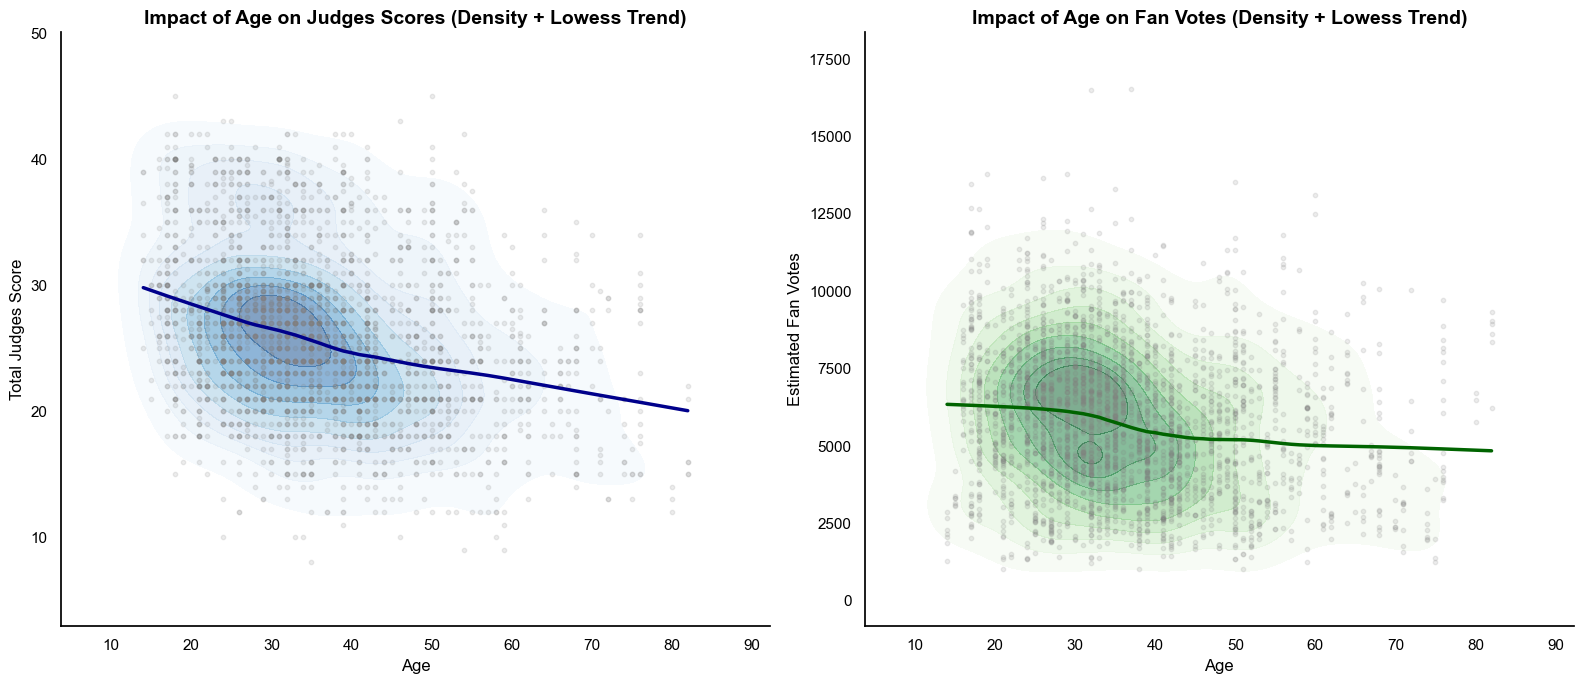

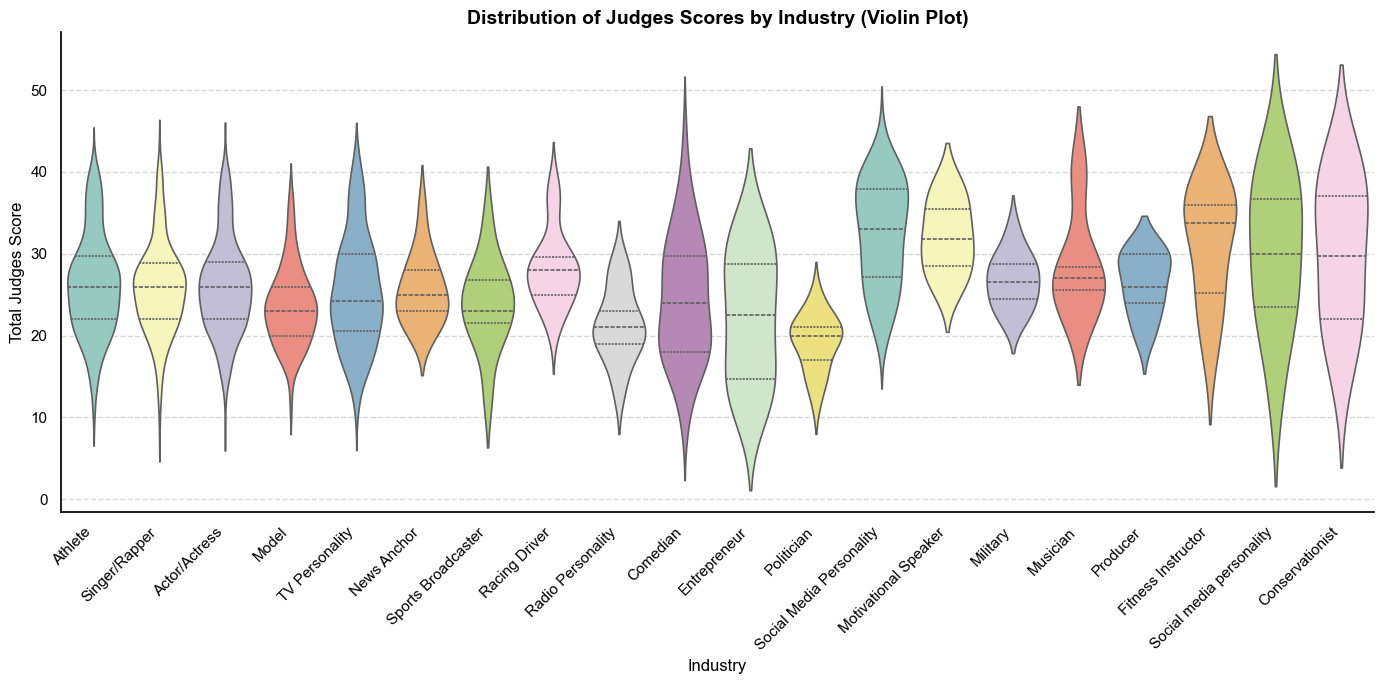

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pathlib import Path
import statsmodels.api as sm # 确保已安装

output_dir = Path.cwd()
if output_dir.name != "paper_writing":
    if (output_dir / "paper_writing").is_dir():
        output_dir = output_dir / "paper_writing"
    else:
        output_dir = output_dir / "paper" / "paper_writing"
output_dir.mkdir(parents=True, exist_ok=True)

# -------------------------------------------------------------------------
# 1. 全局绘图风格设置 (核心修改部分)
# -------------------------------------------------------------------------
# 设置 Seaborn 风格为白色背景
sns.set_style("white")
sns.set_context("notebook") # 默认大小

# 强制 Matplotlib 使用纯黑色字体和线条
plt.rcParams.update({
    "figure.facecolor": "white",  # 图片背景色
    "axes.facecolor": "white",    # 坐标轴背景色
    "savefig.facecolor": "white", # 保存图片时的背景色
    "text.color": "black",        # 文本颜色
    "axes.labelcolor": "black",   # 坐标轴标签颜色
    "xtick.color": "black",       # X轴刻度颜色
    "ytick.color": "black",       # Y轴刻度颜色
    "axes.edgecolor": "black",    # 坐标轴边框颜色
    "patch.edgecolor": "black",   # 图形边缘颜色
    "font.family": "sans-serif",  # 字体设置
})

# -------------------------------------------------------------------------
# 2. 加载数据
# -------------------------------------------------------------------------
# 请确保 '汇总表.csv' 在当前目录下
try:
    df = pd.read_csv('汇总表.csv')
    print("数据加载成功！")
except FileNotFoundError:
    print("错误：找不到 '汇总表.csv' 文件，请检查路径。")
    # 为了演示代码运行，这里生成少量模拟数据 (如果找不到文件)
    import numpy as np
    np.random.seed(42)
    df = pd.DataFrame({
        'celebrity_age_during_season': np.random.randint(20, 60, 200),
        'judges_total_score': np.random.normal(25, 5, 200),
        'estimated_fan_votes': np.random.normal(10000, 2000, 200),
        'celebrity_industry': np.random.choice(['Actor', 'Singer', 'Comedian', 'Model', 'Host'], 200)
    })

# -------------------------------------------------------------------------
# 3. Analysis 1: Age vs Scores & Votes (KDE + Lowess)
# -------------------------------------------------------------------------
plt.figure(figsize=(16, 7))

# --- Subplot 1: Age vs Judges Scores ---
plt.subplot(1, 2, 1)
# KDE Plot
sns.kdeplot(x='celebrity_age_during_season', y='judges_total_score', data=df,
            fill=True, cmap="Blues", thresh=0.05, alpha=0.5, levels=10)
# Reg Plot (Lowess)
sns.regplot(x='celebrity_age_during_season', y='judges_total_score', data=df,
            scatter_kws={'alpha':0.15, 'color':'grey', 's':10},
            line_kws={'color':'darkblue', 'linewidth':2.5},
            lowess=True)

plt.title('Impact of Age on Judges Scores (Density + Lowess Trend)', fontsize=14, fontweight='bold')
plt.xlabel('Age', fontsize=12)
plt.ylabel('Total Judges Score', fontsize=12)

# --- Subplot 2: Age vs Fan Votes ---
plt.subplot(1, 2, 2)
# KDE Plot
sns.kdeplot(x='celebrity_age_during_season', y='estimated_fan_votes', data=df,
            fill=True, cmap="Greens", thresh=0.05, alpha=0.5, levels=10)
# Reg Plot (Lowess)
sns.regplot(x='celebrity_age_during_season', y='estimated_fan_votes', data=df,
            scatter_kws={'alpha':0.15, 'color':'grey', 's':10},
            line_kws={'color':'darkgreen', 'linewidth':2.5},
            lowess=True)

plt.title('Impact of Age on Fan Votes (Density + Lowess Trend)', fontsize=14, fontweight='bold')
plt.xlabel('Age', fontsize=12)
plt.ylabel('Estimated Fan Votes', fontsize=12)

# 去除顶部和右侧的边框 (使图表更清爽，符合白色背景风格)
sns.despine()

plt.tight_layout()
plt.savefig(output_dir / 'age_kde_lowess.png')
plt.show()

# -------------------------------------------------------------------------
# 4. Analysis 2: Performance by Industry (Violin Plot)
# -------------------------------------------------------------------------
# 筛选前20个行业
if 'celebrity_industry' in df.columns:
    top_industries = df['celebrity_industry'].value_counts().nlargest(20).index
    df_top_ind = df[df['celebrity_industry'].isin(top_industries)]

    plt.figure(figsize=(14, 7))
    
    sns.violinplot(x='celebrity_industry', y='judges_total_score', data=df_top_ind,
                   palette="Set3", inner="quartile", linewidth=1.2, hue='celebrity_industry')

    plt.xticks(rotation=45, ha='right')
    
    plt.title('Distribution of Judges Scores by Industry (Violin Plot)', fontsize=14, fontweight='bold')
    plt.xlabel('Industry', fontsize=12)
    plt.ylabel('Total Judges Score', fontsize=12)
    
    # 也可以手动添加黑色网格线（可选）
    plt.grid(axis='y', linestyle='--', alpha=0.3, color='grey')
    
    sns.despine() # 去除上右边框
    plt.tight_layout()
    plt.savefig(output_dir / 'industry_violin_judges.png')
    plt.show()
else:
    print("数据中未找到 'celebrity_industry' 列，跳过行业分析图表。")

#  使用随机森林进行多元分析

C:\Users\kqdx\AppData\Local\Temp\ipykernel_3948\3910740174.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Industry_Group', y='celebrity_age_during_season', data=df_model, palette="Set3")


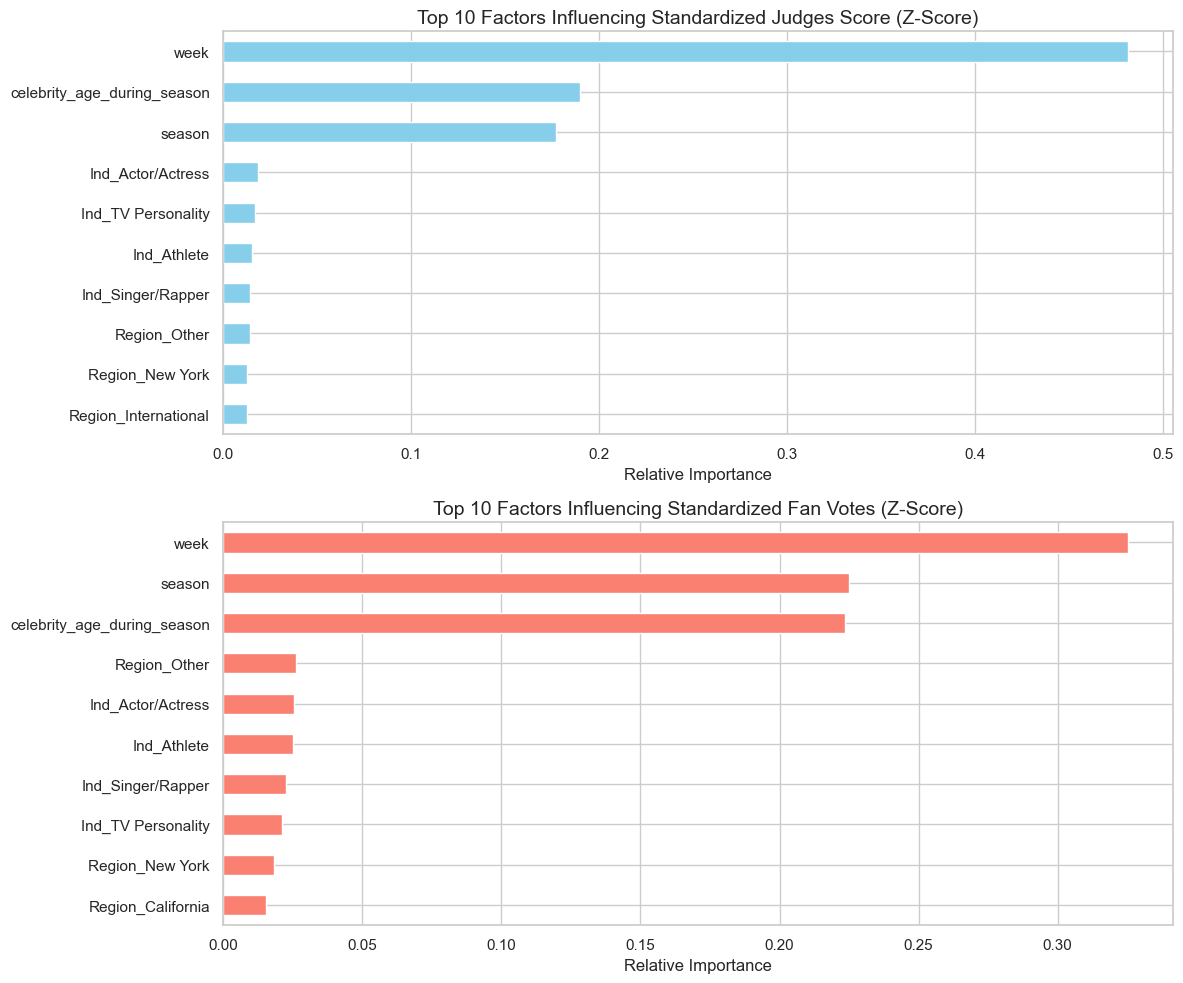

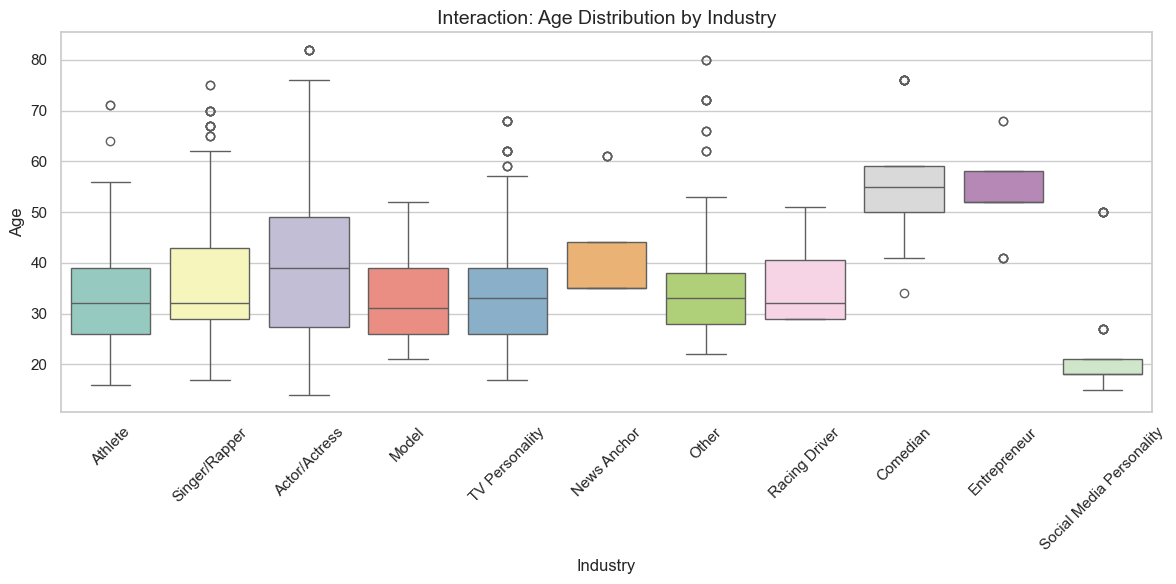

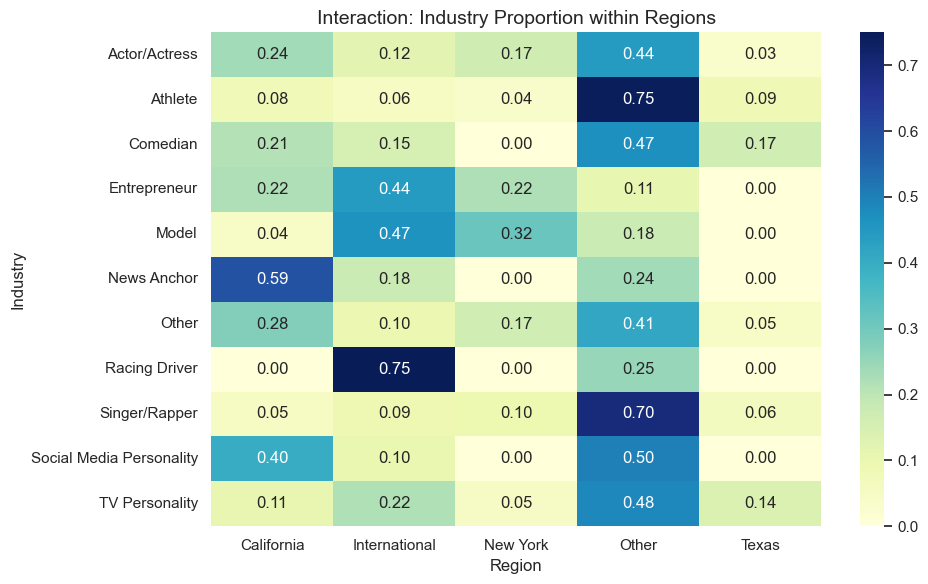

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from pathlib import Path

output_dir = Path.cwd()
if output_dir.name != "paper_writing":
    if (output_dir / "paper_writing").is_dir():
        output_dir = output_dir / "paper_writing"
    else:
        output_dir = output_dir / "paper" / "paper_writing"
output_dir.mkdir(parents=True, exist_ok=True)

# 1. 数据读取
df = pd.read_csv("汇总表.csv")

# ==========================================
# 核心修改：赛季内 Z-Score 标准化
# ==========================================
# 定义标准化函数
def z_score(x):
    if x.std() == 0:
        return x - x.mean()
    return (x - x.mean()) / x.std()

# 按赛季分组计算 Z-Score
# 这样处理后，分数代表的是"该选手比该赛季平均水平高/低多少个标准差"
df['judges_score_z'] = df.groupby('season')['judges_total_score'].transform(z_score)
df['fan_votes_z'] = df.groupby('season')['estimated_fan_votes'].transform(z_score)

# 2. 特征工程 (保持原有逻辑)
df_model = df.copy()

# (1) 职业处理：保留Top 10
top_industries = df_model['celebrity_industry'].value_counts().nlargest(10).index
df_model['Industry_Group'] = df_model['celebrity_industry'].apply(lambda x: x if x in top_industries else 'Other')

# (2) 地区处理
df_model['Is_US'] = (df_model['celebrity_homecountry/region'] == 'United States').astype(int)
df_model['State_Group'] = df_model['celebrity_homestate'].apply(
    lambda x: x if x in ['California', 'New York', 'Texas'] else 'Other'
)
df_model['State_Group'] = df_model.apply(
    lambda row: 'International' if row['Is_US'] == 0 else row['State_Group'], axis=1
)

# (3) 独热编码
df_encoded = pd.get_dummies(df_model[['Industry_Group', 'State_Group']], prefix=['Ind', 'Region'])

# 拼接数据，注意这里 Target 换成了 Z-score 列
df_final = pd.concat([
    df_model[['season', 'week', 'celebrity_age_during_season', 'judges_score_z', 'fan_votes_z']], 
    df_encoded
], axis=1).dropna()

# 3. 建立随机森林模型
X = df_final.drop(columns=['judges_score_z', 'fan_votes_z'])
y_judge = df_final['judges_score_z']  # 预测相对排位能力
y_fan = df_final['fan_votes_z']

rf_judge = RandomForestRegressor(n_estimators=100, random_state=42).fit(X, y_judge)
rf_fan = RandomForestRegressor(n_estimators=100, random_state=42).fit(X, y_fan)

# 4. 可视化结果 (全英文图表)
sns.set(style="whitegrid")

# 图1: 特征重要性 (Feature Importance) - Z-Score版
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
feat_importances_judge = pd.Series(rf_judge.feature_importances_, index=X.columns)
feat_importances_judge.nlargest(10).sort_values().plot(kind='barh', color='skyblue')
plt.title('Top 10 Factors Influencing Standardized Judges Score (Z-Score)', fontsize=14)
plt.xlabel('Relative Importance')

plt.subplot(2, 1, 2)
feat_importances_fan = pd.Series(rf_fan.feature_importances_, index=X.columns)
feat_importances_fan.nlargest(10).sort_values().plot(kind='barh', color='salmon')
plt.title('Top 10 Factors Influencing Standardized Fan Votes (Z-Score)', fontsize=14)
plt.xlabel('Relative Importance')

plt.tight_layout()
plt.savefig(output_dir / 'feature_importance_zscore.png')

# 图2: 职业与年龄交互 (Boxplot)
plt.figure(figsize=(12, 6))
sns.boxplot(x='Industry_Group', y='celebrity_age_during_season', data=df_model, palette="Set3")
plt.title('Interaction: Age Distribution by Industry', fontsize=14)
plt.xlabel('Industry')
plt.ylabel('Age')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(output_dir / 'age_industry_interaction_v2.png')

# 图3: 职业与地区交互热力图
ct = pd.crosstab(df_model['Industry_Group'], df_model['State_Group'], normalize='index')
plt.figure(figsize=(10, 6))
sns.heatmap(ct, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Interaction: Industry Proportion within Regions', fontsize=14)
plt.ylabel('Industry')
plt.xlabel('Region')
plt.tight_layout()
plt.savefig(output_dir / 'region_industry_heatmap_v2.png')

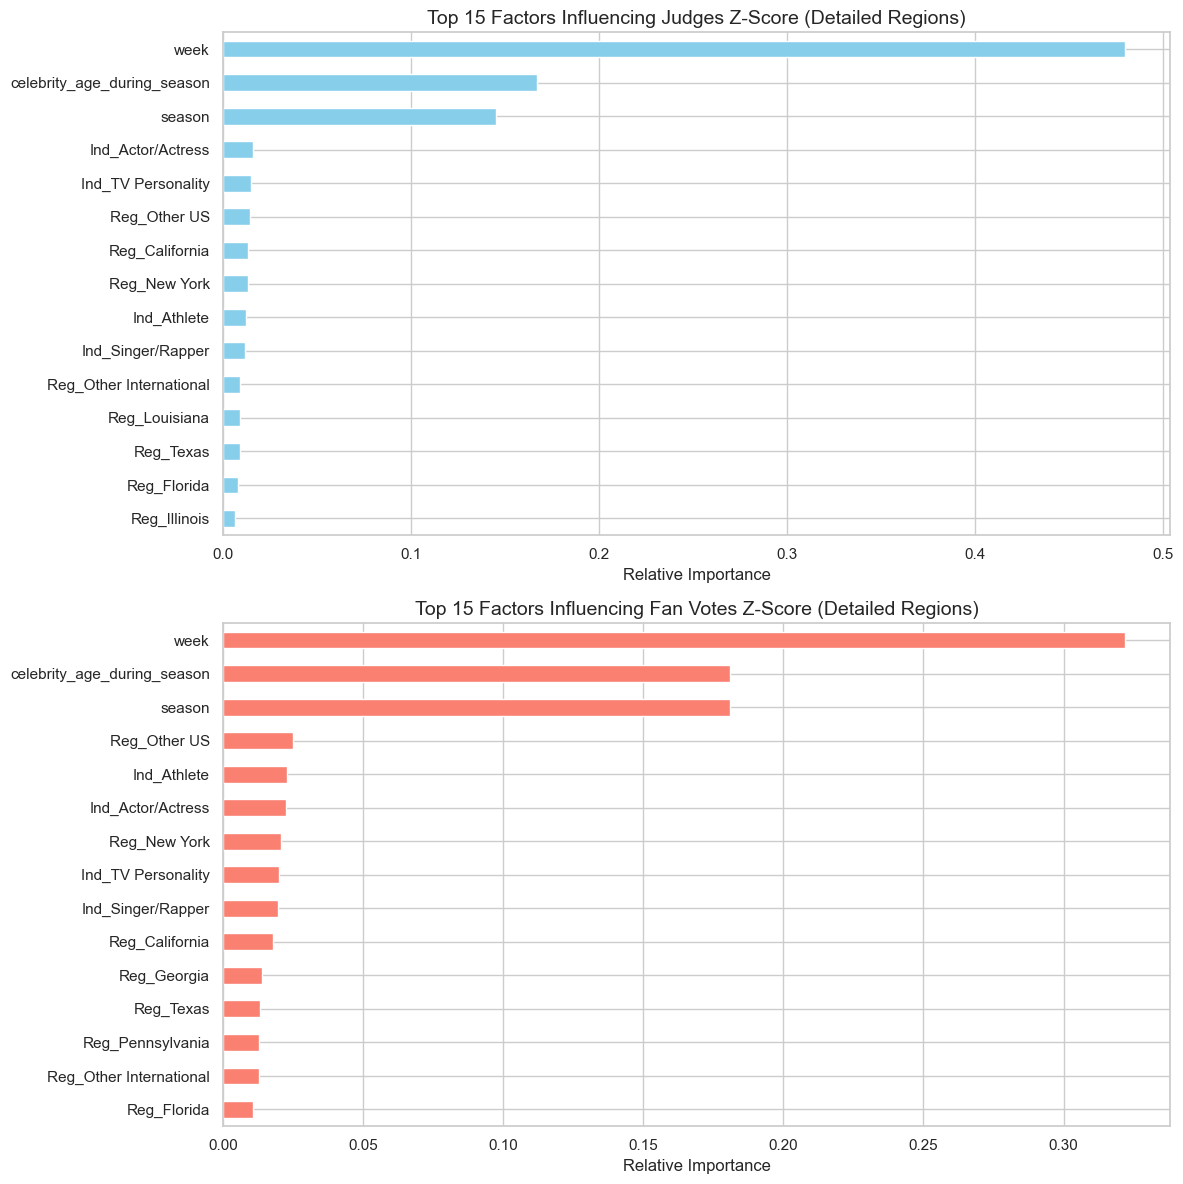

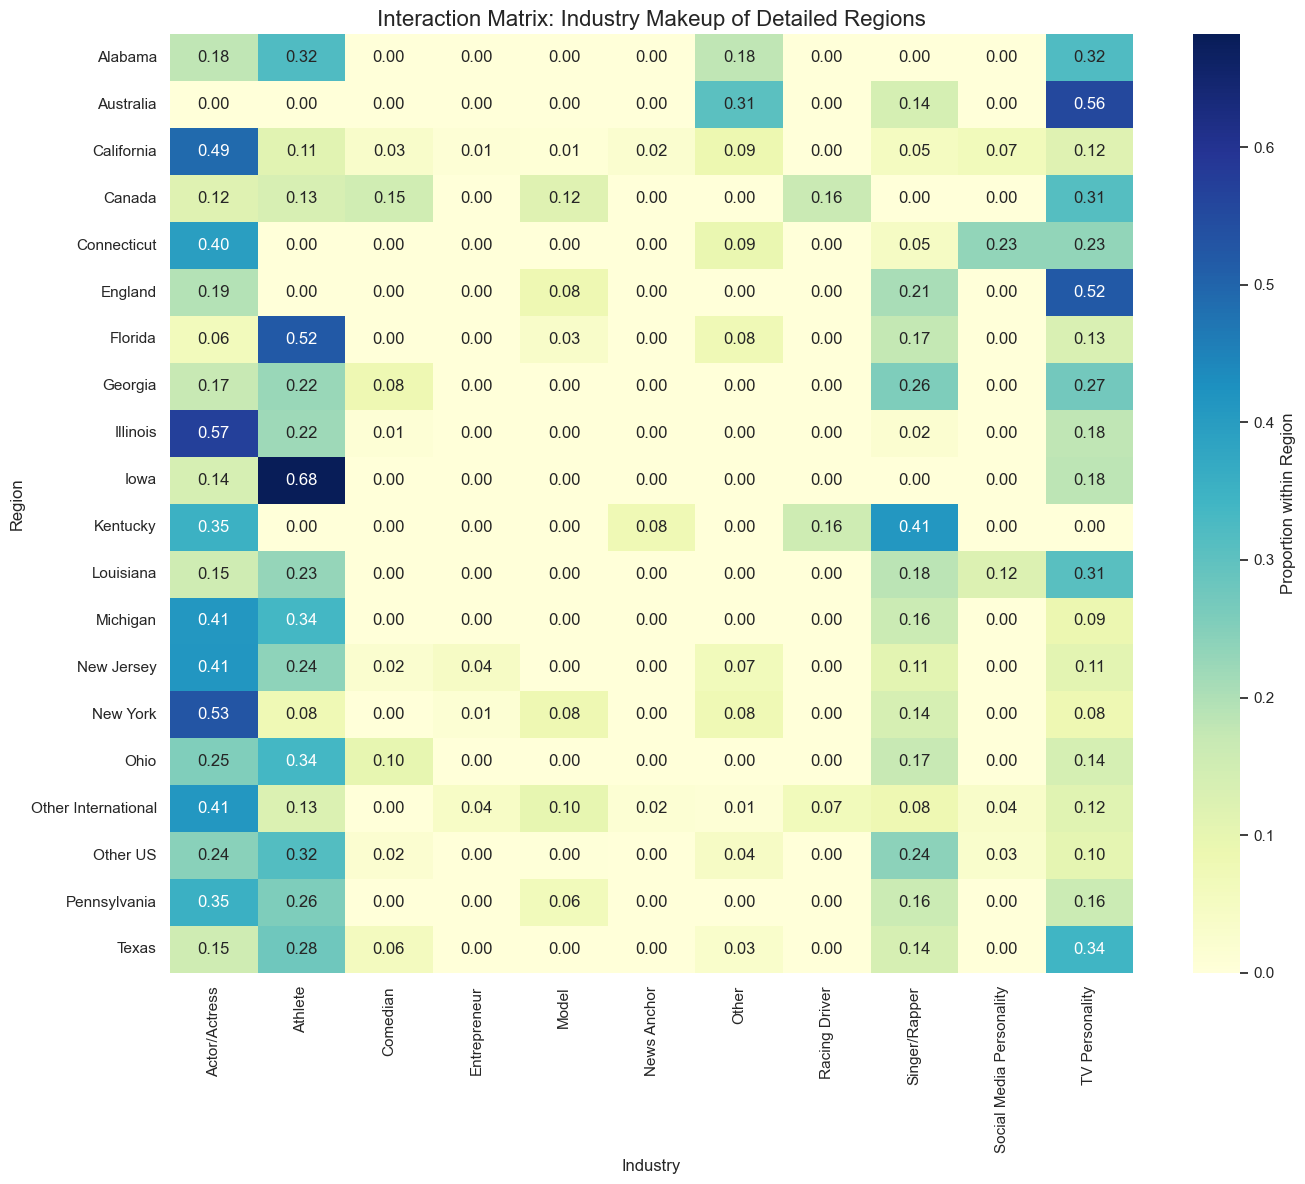

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from pathlib import Path

output_dir = Path.cwd()
if output_dir.name != "paper_writing":
    if (output_dir / "paper_writing").is_dir():
        output_dir = output_dir / "paper_writing"
    else:
        output_dir = output_dir / "paper" / "paper_writing"
output_dir.mkdir(parents=True, exist_ok=True)

# 1. 数据读取
df = pd.read_csv("汇总表.csv")

# 2. Z-Score 标准化 (消除赛季差异)
def z_score(x):
    if x.std() == 0:
        return x - x.mean()
    return (x - x.mean()) / x.std()

df['judges_score_z'] = df.groupby('season')['judges_total_score'].transform(z_score)
df['fan_votes_z'] = df.groupby('season')['estimated_fan_votes'].transform(z_score)

# 3. 特征工程：细化地区与职业
df_model = df.copy()

# (1) 职业：保留 Top 10
top_industries = df_model['celebrity_industry'].value_counts().nlargest(10).index
df_model['Industry_Group'] = df_model['celebrity_industry'].apply(lambda x: x if x in top_industries else 'Other')

# (2) 地区：极细颗粒度处理
# 提取美国前15个州
top_15_states = df_model[df_model['celebrity_homecountry/region'] == 'United States']['celebrity_homestate'].value_counts().nlargest(15).index.tolist()
# 提取非美国前3个国家
top_3_countries = df_model[df_model['celebrity_homecountry/region'] != 'United States']['celebrity_homecountry/region'].value_counts().nlargest(3).index.tolist()

def get_region_detailed(row):
    if row['celebrity_homecountry/region'] == 'United States':
        state = row['celebrity_homestate']
        if state in top_15_states:
            return state # 保留具体州名，如 'Florida', 'Ohio'
        else:
            return 'Other US'
    else:
        country = row['celebrity_homecountry/region']
        if country in top_3_countries:
            return country # 保留具体国家名，如 'England'
        else:
            return 'Other International'

df_model['Region_Detailed'] = df_model.apply(get_region_detailed, axis=1)

# (3) 独热编码
df_encoded = pd.get_dummies(df_model[['Industry_Group', 'Region_Detailed']], prefix=['Ind', 'Reg'])

# 拼接数据
df_final = pd.concat([
    df_model[['season', 'week', 'celebrity_age_during_season', 'judges_score_z', 'fan_votes_z']], 
    df_encoded
], axis=1).dropna()

# 4. 训练模型
X = df_final.drop(columns=['judges_score_z', 'fan_votes_z'])
y_judge = df_final['judges_score_z']
y_fan = df_final['fan_votes_z']

rf_judge = RandomForestRegressor(n_estimators=100, random_state=42).fit(X, y_judge)
rf_fan = RandomForestRegressor(n_estimators=100, random_state=42).fit(X, y_fan)

# 5. 可视化结果

sns.set(style="whitegrid")

# 图1: 特征重要性 Top 15 (查看是否有特定州上榜)
plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
feat_importances_judge = pd.Series(rf_judge.feature_importances_, index=X.columns)
feat_importances_judge.nlargest(15).sort_values().plot(kind='barh', color='skyblue')
plt.title('Top 15 Factors Influencing Judges Z-Score (Detailed Regions)', fontsize=14)
plt.xlabel('Relative Importance')

plt.subplot(2, 1, 2)
feat_importances_fan = pd.Series(rf_fan.feature_importances_, index=X.columns)
feat_importances_fan.nlargest(15).sort_values().plot(kind='barh', color='salmon')
plt.title('Top 15 Factors Influencing Fan Votes Z-Score (Detailed Regions)', fontsize=14)
plt.xlabel('Relative Importance')

plt.tight_layout()
plt.savefig(output_dir / 'feature_importance_detailed.png')

# 图2: 细分地区与职业的交互热力图
# 纵轴为地区，横轴为职业，颜色深浅代表该职业在该地区的占比
ct = pd.crosstab(df_model['Region_Detailed'], df_model['Industry_Group'], normalize='index')
plt.figure(figsize=(14, 12)) # 加大画布以容纳更多地区标签
sns.heatmap(ct, annot=True, cmap='YlGnBu', fmt='.2f', cbar_kws={'label': 'Proportion within Region'})
plt.title('Interaction Matrix: Industry Makeup of Detailed Regions', fontsize=16)
plt.ylabel('Region')
plt.xlabel('Industry')
plt.tight_layout()
plt.savefig(output_dir / 'region_detailed_industry_heatmap.png')